### Load libraries

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

### Path to all results

In [2]:
# Define the main directory path
main_directory = "/Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization"  

# Verify the directory exists
if not os.path.isdir(main_directory):
    print(f"Error: The directory '{main_directory}' does not exist.")
else:
    print(f"Main directory found: {main_directory}")

Main directory found: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization


### Contributing sites details

In [6]:
# Mapping from directory names to full university names
DIR_TO_UNIVERSITY = {
    'hopkins': "Johns Hopkins University",
    'nu': "Northwestern University",
    'ohsu': "Oregon Health & Science University",
    'ucmc': "University of Chicago",
    'Michigan': "University of Michigan",
    'rush': "Rush University",
    'umn': "University of Minnesota",
    'penn': "University of Pennsylvania",
    'MIMIC': "MIMIC IV"
}

# Mapping from directory names to site names used in filenames
DIR_TO_SITE_NAME = {
    'hopkins': "Hopkins",
    'nu': "NU",
    'ohsu': "ohsu",
    'ucmc': "UCMC",
    'Michigan': "U Michigan",
    'rush': "RUSH",
    'umn': "UMN",
    'penn': "Penn",
    'MIMIC': "MIMIC"
}

# Mapping from full university names to official colors (Hex codes)
UNIVERSITY_COLORS = {
    "Johns Hopkins University": "#000000",          
    "Northwestern University": "#4E2A84",           
    "Oregon Health & Science University": "#5D98CA", 
    "University of Chicago": "#800000",              
    "University of Michigan": "#0000F5",            
    "Rush University": "#006747",                     
    "University of Minnesota": "#F9D849",           
    "University of Pennsylvania": "#FF0000",
    "MIMIC IV": "#AA336A",           
}

# Criteria types and corresponding keywords in filenames
CRITERIA_TYPES = {
    'patel': 'Patel Criteria',
    'team': 'TEAM Criteria',
    'yellow': 'Consensus Guidelines Criteria'
}

# Mapping from site_name to university names
site_to_university = {v: DIR_TO_UNIVERSITY[k] for k, v in DIR_TO_SITE_NAME.items()}

### Aggregate cumulative incidence plot

In [7]:
def construct_file_path(site_dir, criteria, site_name, main_dir):
    """
    Constructs the file path for a given site and criteria.
    
    Parameters:
        site_dir (str): Subdirectory name (e.g., 'Michigan').
        criteria (str): Criteria type ('patel', 'team', 'consensus guidelines ').
        site_name (str): Site name used in the filename (e.g., 'U Michigan').
        main_dir (str): Path to the main directory.
    
    Returns:
        str or None: Full path to the CSV file or None if not found.
    """
    # Define the expected filename pattern with wildcard for timestamp
    pattern = f'cif_b_hours_{criteria}_{site_name}_*.csv'
    search_path = os.path.join(main_dir, site_dir, pattern)
    matched_files = glob.glob(search_path)
    
    if not matched_files:
        print(f"    Warning: No file found for criteria '{criteria}' in site '{site_dir}'.")
        return None
    elif len(matched_files) > 1:
        print(f"    Warning: Multiple files found for criteria '{criteria}' in site '{site_dir}'. Using the first match.")
    
    # Return the first matched file
    return matched_files[0]

def read_and_process_file(file_path, criterion_type, university_name):
    """
    Reads a CSV file and processes it for aggregation.
    
    Parameters:
        file_path (str): Path to the CSV file.
        criterion_type (str): Human-readable criterion type (e.g., 'Patel Criteria').
        university_name (str): Full name of the university.
    
    Returns:
        pd.DataFrame: Processed DataFrame with standardized column names.
    """
    try:
        print(f"      Reading file: {file_path}")
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Check if the file has exactly four columns
        if df.shape[1] != 4:
            print(f"      Error: Expected 4 columns in {file_path}, but found {df.shape[1]}. Skipping this file.")
            return pd.DataFrame()
        
        # Assign standard column names regardless of original names
        df.columns = ['timeline', 'value', 'criteria', 'site']
        
        # Optional: Display the first few rows to verify
        # display(df.head())
        
        # Add additional columns for aggregation
        df['criterion_type'] = criterion_type
        df['university'] = university_name
        
        # Select relevant columns for aggregation
        df = df[['timeline', 'value', 'criterion_type', 'university']]
        
        return df
    
    except Exception as e:
        print(f"      Error reading {file_path}: {e}")
        return pd.DataFrame()

def aggregate_all_sites(main_dir):
    """
    Aggregates data from all site directories.
    
    Parameters:
        main_dir (str): Path to the main directory containing site subdirectories.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame containing data from all sites and criteria.
    """
    aggregated_df = pd.DataFrame()
    
    # Iterate through each site directory
    for site_dir, university_name in DIR_TO_UNIVERSITY.items():
        site_name_in_file = DIR_TO_SITE_NAME.get(site_dir, "")
        
        if not site_name_in_file:
            print(f"\n  Warning: No site name mapping found for directory '{site_dir}'. Skipping.")
            continue
        
        print(f"\nProcessing site: {university_name} ({site_dir})")
        
        for criteria_key, criterion_type in CRITERIA_TYPES.items():
            print(f"  Processing criteria: {criterion_type}")
            file_path = construct_file_path(site_dir, criteria_key, site_name_in_file, main_dir)
            
            if file_path:
                df = read_and_process_file(file_path, criterion_type, university_name)
                
                if not df.empty:
                    aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
                else:
                    print(f"  Warning: DataFrame is empty for file '{file_path}'.")
            else:
                print(f"  Warning: File for criteria '{criteria_key}' not found in site '{site_dir}'.")
    
    return aggregated_df

In [8]:
# Aggregate data from all sites
aggregated_df1 = aggregate_all_sites(main_directory)

# Check if data was aggregated
if aggregated_df1.empty:
    print("No data was aggregated. Please check the directory structure and file naming conventions.")
else:
    print(f"\nTotal aggregated records: {len(aggregated_df1)}")


Processing site: Johns Hopkins University (hopkins)
  Processing criteria: Patel Criteria
      Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/hopkins/cif_b_hours_patel_Hopkins_2024-11-04_16-10-37.csv
  Processing criteria: TEAM Criteria
      Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/hopkins/cif_b_hours_team_Hopkins_2024-11-04_16-10-37.csv
  Processing criteria: Consensus Guidelines Criteria
      Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/hopkins/cif_b_hours_yellow_Hopkins_2024-11-04_16-10-37.csv

Processing site: Northwestern University (nu)
  Processing criteria: Patel Criteria
      Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/nu/cif_b_hours_patel_NU_2024-11-02_19-46-57.csv
  Processing criteria: TEAM Criteria
   

In [9]:
print("\nAggregated Data Preview:")
display(aggregated_df1.head())

# Display information about the DataFrame
print("\nAggregated Data Info:")
aggregated_df1.info()


Aggregated Data Preview:


,timeline,value,criterion_type,university
0,0.0,0.000000,Patel Criteria,Johns Hopkins University
1,1.0,0.683824,Patel Criteria,Johns Hopkins University
2,2.0,0.809492,Patel Criteria,Johns Hopkins University
3,3.0,0.868850,Patel Criteria,Johns Hopkins University
4,4.0,0.903209,Patel Criteria,Johns Hopkins University



Aggregated Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timeline        714 non-null    float64
 1   value           714 non-null    float64
 2   criterion_type  714 non-null    object 
 3   university      714 non-null    object 
dtypes: float64(2), object(2)
memory usage: 22.4+ KB


In [10]:
def plot_aggregated_data(aggregated_df):
    """
    Plots the aggregated data in three panels, one for each criterion,
    with y-axis fixed from 0 to 1 and a legend positioned below the plots.
    
    Parameters:
        aggregated_df (pd.DataFrame): Aggregated DataFrame containing all sites and criteria.
    """
    # Ensure 'timeline' is numeric
    aggregated_df['timeline'] = pd.to_numeric(aggregated_df['timeline'], errors='coerce')
    
    # Drop rows with NaN 'timeline' or 'value'
    aggregated_df = aggregated_df.dropna(subset=['timeline', 'value'])
    
    # Sort by 'timeline'
    aggregated_df = aggregated_df.sort_values('timeline')
    
    # Initialize a FacetGrid with three columns for each criterion
    g = sns.FacetGrid(
        aggregated_df, 
        col='criterion_type', 
        sharey=True,  # Share y-axis to ensure consistent scaling
        height=6, 
        aspect=1.2
    )
    
    # Define a palette based on university colors
    palette = UNIVERSITY_COLORS
    
    # Plot each facet without an internal legend
    g.map_dataframe(
        sns.lineplot, 
        x='timeline', 
        y='value', 
        hue='university', 
        palette=palette,
        legend=False  # Disable internal legends
    )
    
    # Create custom legend handles
    custom_handles = [
        Line2D([0], [0], color=color, lw=2) for color in palette.values()
    ]
    custom_labels = list(palette.keys())
    
    # Add a single legend below the plots
    g.fig.legend(
        handles=custom_handles, 
        labels=custom_labels, 
        # title='Hospitals', 
        loc='lower center', 
        ncol=5, 
        bbox_to_anchor=(0.5, -0.02)  # Position the legend below the plots
        # ncol=len(custom_labels),  # Adjust ncol to cover the entire width
        # bbox_to_anchor=(0.5, -0.0003)  # Adjust position to cover the entire width
    )
    
    # Adjust the layout to make space for the legend
    plt.subplots_adjust(top=0.85, bottom=0.25, right=0.9)  # Increase the bottom margin for the legend
    
    # Set titles and labels
    g.set_titles("{col_name}")
    g.set_axis_labels("Timeline (Business Hours)", "Cumulative Incidence Probability")
    
    # Set y-axis limits from 0 to 1 for all plots
    g.set(ylim=(0, 1))
    
    # Set a super title for the entire figure
    plt.suptitle('Cumulative Incidence Function for Time to First Eligibility Across CLIF Sites', fontsize=16)
    
    plt.show()

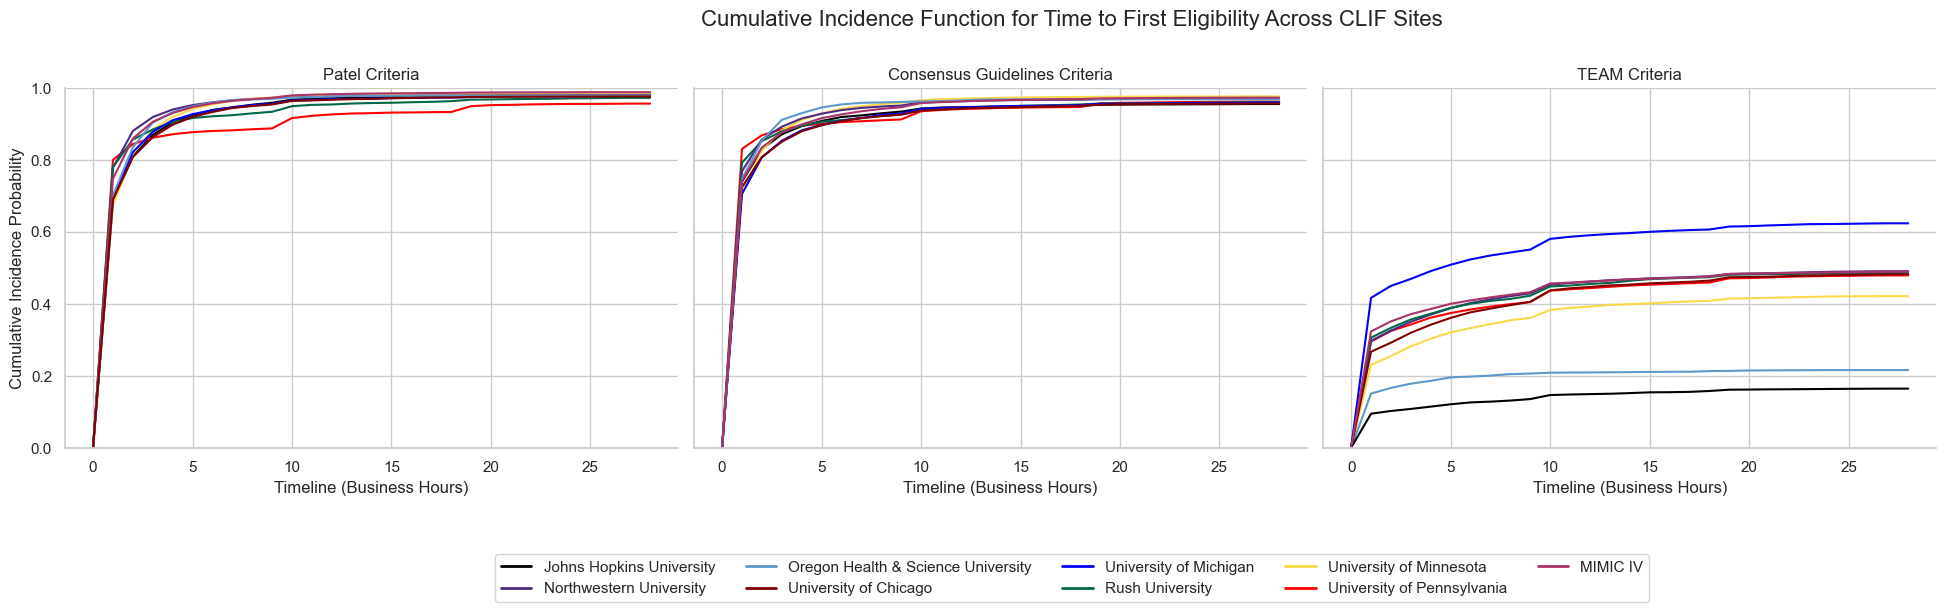

In [11]:
# Configure seaborn aesthetics
sns.set(style="whitegrid")
plot_aggregated_data(aggregated_df1)

In [12]:
aggregated_df1.value_counts('university')

university
University of Pennsylvania            87
MIMIC IV                              86
Rush University                       86
Johns Hopkins University              83
University of Michigan                83
University of Chicago                 82
Northwestern University               78
University of Minnesota               77
Oregon Health & Science University    52
Name: count, dtype: int64

In [13]:
# Mapping of universities to their number of subjects
n_mapping = {
    'Johns Hopkins University': 7676,
    'University of Chicago': 4200,
    'University of Michigan': 3826,
    'University of Pennsylvania': 6747,
    'Rush University': 2778,
    'University of Minnesota': 6021,
    'Northwestern University': 24170,
    'MIMIC IV': 23372,
    'Oregon Health & Science University': 3197
}

In [19]:
# Add 'n' column by mapping the 'university' column
aggregated_df1['n'] = aggregated_df1['university'].map(n_mapping)

In [28]:
# Filter the DataFrame for timeline = 1.0 hour
df_at_1_hour = aggregated_df1[aggregated_df1['timeline'] == 1.0]
# Group by 'criterion_type' and calculate the weighted CIF at 1 hour using sum of 'n' per group
overall_cif_at_1_hour = df_at_1_hour.groupby('criterion_type').apply(
    lambda x: (x['value'] * x['n']).sum() / x['n'].sum()
)

# Convert to percentage
overall_cif_at_1_hour_percent = overall_cif_at_1_hour * 100

# Display the results
print(overall_cif_at_1_hour_percent)

criterion_type
Consensus Guidelines Criteria    75.258563
Patel Criteria                   74.264853
TEAM Criteria                    27.880287
dtype: float64


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_87161/3520267522.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall_cif_at_1_hour = df_at_1_hour.groupby('criterion_type').apply(


In [31]:
# Filter the DataFrame for timeline = 1.0 hour
df_at_1_hour = aggregated_df1[aggregated_df1['timeline'] == 3.0]
# Group by 'criterion_type' and calculate the weighted CIF at 1 hour using sum of 'n' per group
overall_cif_at_1_hour = df_at_1_hour.groupby('criterion_type').apply(
    lambda x: (x['value'] * x['n']).sum() / x['n'].sum()
)

# Convert to percentage
overall_cif_at_1_hour_percent = overall_cif_at_1_hour * 100

# Display the results
print(overall_cif_at_1_hour_percent)

criterion_type
Consensus Guidelines Criteria    87.987041
Patel Criteria                   89.602801
TEAM Criteria                    32.486658
dtype: float64


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_87161/3963640759.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall_cif_at_1_hour = df_at_1_hour.groupby('criterion_type').apply(


## Proportion of Eligible Hours and Encounters

In [24]:
def read_and_process_aggregate_file(file_path, site_name):
    """
    Reads an aggregates CSV file and processes it for analysis.
    
    Parameters:
        file_path (str): Path to the aggregates CSV file.
        site_name (str): Name of the site (derived from directory name).
    
    Returns:
        pd.DataFrame: Processed DataFrame with computed proportions.
    """
    try:
        print(f"  Reading file: {file_path}")
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Check if the file has the expected number of columns
        print("Printing existing columns:", df.columns)
        expected_columns = ['Criteria', 'Total Patients', 'Eligible Patients', 
                            'Total Observed Hours', 'Eligible Hours', 
                            'Median Time', 'CI Lower Median Time', 'CI Upper Median Time']
        if not all(col in df.columns for col in expected_columns):
            # print("Printing existing columns:", df.columns)
            print("Expected columns:", expected_columns)
            print(f"    Error: Missing required columns in {file_path}. Skipping this file.")
            return pd.DataFrame()
        
        # Assign standard column names if necessary (optional)
        df.columns = ['Criteria', 'Total Patients', 'Eligible Patients', 
                      'Total Observed Hours', 'Eligible Hours', 
                      'Median Time', 'CI Lower Median Time', 'CI Upper Median Time']
        
        # Add a column for site_name
        df['site_name'] = site_name
        
        # Compute proportions
        df['proportion_encounter'] = df['Eligible Patients'] / df['Total Patients']
        df['proportion_hours'] = df['Eligible Hours'] / df['Total Observed Hours']
        
        # Select relevant columns for aggregation
        # df = df[['site_name', 'Criteria', 'proportion_encounter', 'proportion_hours']]
        
        return df
    
    except Exception as e:
        print(f"    Error reading {file_path}: {e}")
        return pd.DataFrame()
    
def aggregate_all_aggregate_files(main_dir):
    """
    Aggregates data from all 'aggregates_*.csv' files across site directories.
    
    Parameters:
        main_dir (str): Path to the main directory containing site subdirectories.
    
    Returns:
        pd.DataFrame: Combined DataFrame with all aggregated data.
    """
    aggregated_data = pd.DataFrame()
    
    # Iterate through each site directory
    for dir_name, university_name in DIR_TO_UNIVERSITY.items():
        site_name = DIR_TO_SITE_NAME.get(dir_name, "")
        
        if not site_name:
            print(f"\n  Warning: No site name mapping found for directory '{dir_name}'. Skipping.")
            continue
        
        site_dir_path = os.path.join(main_dir, dir_name)
        
        if not os.path.isdir(site_dir_path):
            print(f"\n  Warning: Site directory '{site_dir_path}' does not exist. Skipping.")
            continue
        
        print(f"\nProcessing site: {university_name} ({dir_name})")
        
        # Search for 'aggregates_*.csv' files in the site directory
        pattern = os.path.join(site_dir_path, 'aggregates_*.csv')
        aggregate_files = glob.glob(pattern)
        
        if not aggregate_files:
            print(f"  Warning: No 'aggregates_*.csv' files found in '{site_dir_path}'.")
            continue
        
        for file in aggregate_files:
            processed_df = read_and_process_aggregate_file(file, site_name)
            if not processed_df.empty:
                aggregated_data = pd.concat([aggregated_data, processed_df], ignore_index=True)
    
    return aggregated_data

In [25]:
# Aggregate data from all sites
aggregated_df2 = aggregate_all_aggregate_files(main_directory)

# Check if data was aggregated
if aggregated_df2.empty:
    print("No data was aggregated. Please check the directory structure and file naming conventions.")
else:
    print(f"\nTotal aggregated records: {len(aggregated_df2)}")



Processing site: Johns Hopkins University (hopkins)
  Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/hopkins/aggregates_Hopkins_2024-11-04_16-10-37.csv
Printing existing columns: Index(['Criteria', 'Total Patients', 'Eligible Patients',
       'Total Observed Hours', 'Eligible Hours', 'Median Time',
       'CI Lower Median Time', 'CI Upper Median Time'],
      dtype='object')

Processing site: Northwestern University (nu)
  Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-eligibility-for-mobilization/nu/aggregates_NU_2024-11-02_19-46-57.csv
Printing existing columns: Index(['Criteria', 'Total Patients', 'Eligible Patients',
       'Total Observed Hours', 'Eligible Hours', 'Median Time',
       'CI Lower Median Time', 'CI Upper Median Time'],
      dtype='object')

Processing site: Oregon Health & Science University (ohsu)
  Reading file: /Users/kavenchhikara/Library/CloudStorage/Box-Box/

In [26]:
print("\nAggregated Data Preview:")
display(aggregated_df2.head())

# Display information about the DataFrame
print("\nAggregated Data Info:")
aggregated_df2.info()


Aggregated Data Preview:


,Criteria,Total Patients,Eligible Patients,Total Observed Hours,Eligible Hours,Median Time,CI Lower Median Time,CI Upper Median Time,site_name,proportion_encounter,proportion_hours
0,Patel,7480,7320,186782,142224,2.0,2.0,3.0,Hopkins,0.978610,0.761444
1,TEAM,7480,1226,186782,25201,2.0,2.0,3.0,Hopkins,0.163904,0.134922
2,Yellow,7480,7139,186782,154310,2.0,2.0,3.0,Hopkins,0.954412,0.826150
3,Patel,6836,6709,172289,142405,2.0,2.0,2.0,NU,0.981422,0.826547
4,TEAM,6836,3350,172289,71153,2.0,2.0,2.0,NU,0.490053,0.412986



Aggregated Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Criteria              27 non-null     object 
 1   Total Patients        27 non-null     int64  
 2   Eligible Patients     27 non-null     int64  
 3   Total Observed Hours  27 non-null     int64  
 4   Eligible Hours        27 non-null     int64  
 5   Median Time           27 non-null     float64
 6   CI Lower Median Time  27 non-null     float64
 7   CI Upper Median Time  27 non-null     float64
 8   site_name             27 non-null     object 
 9   proportion_encounter  27 non-null     float64
 10  proportion_hours      27 non-null     float64
dtypes: float64(5), int64(4), object(2)
memory usage: 2.4+ KB


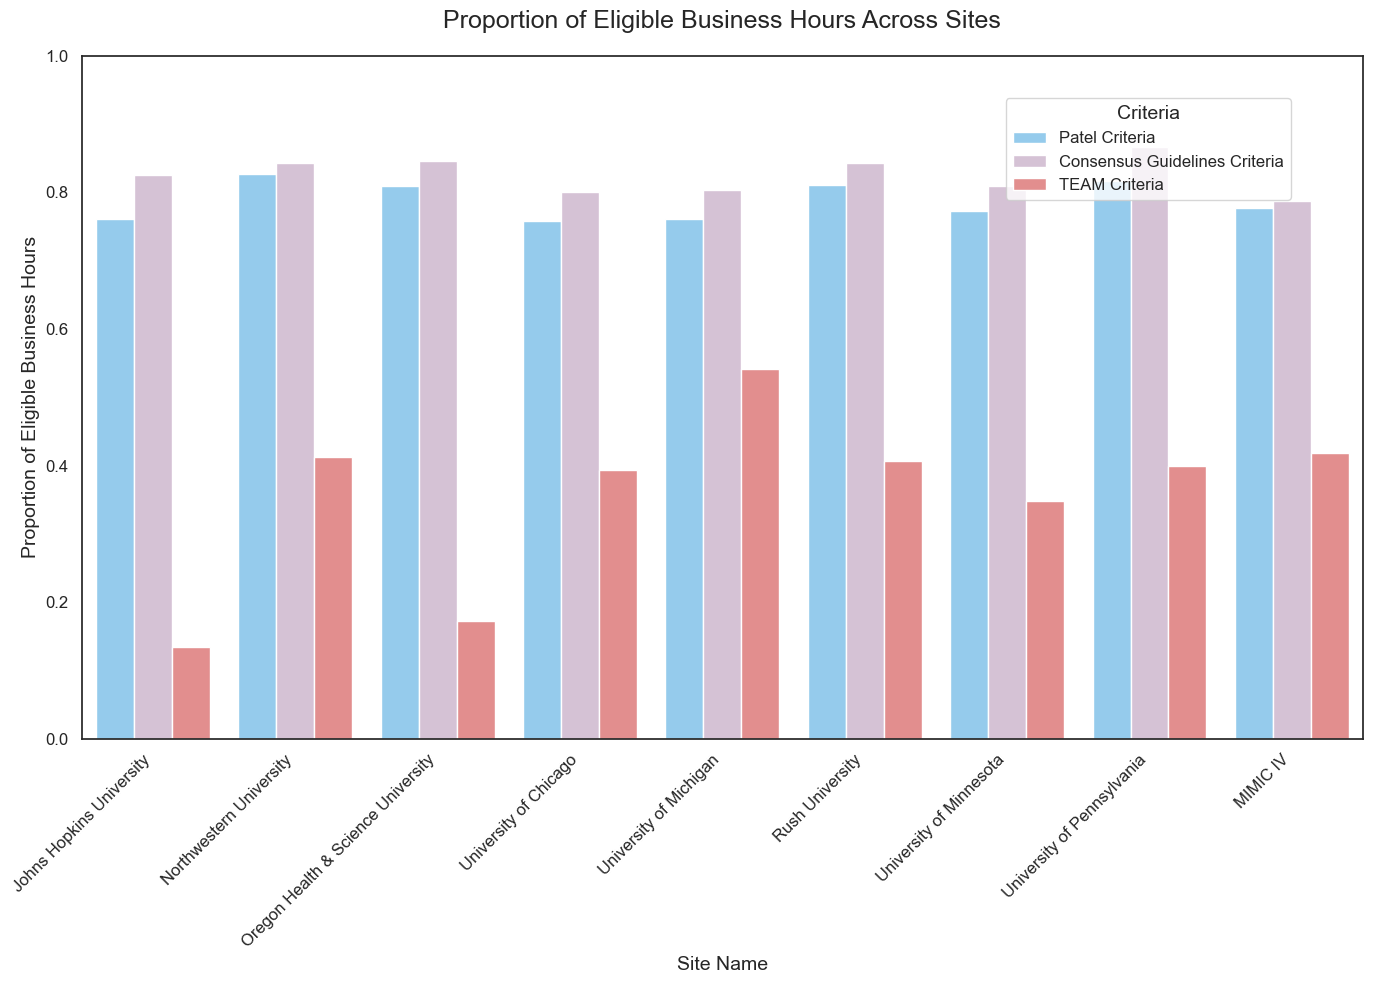

In [27]:
CRITERIA_COLORS = {
    'Patel Criteria': 'lightskyblue',                 # Blue
    'Consensus Guidelines Criteria': 'thistle',  # Yellow
    'TEAM Criteria': 'lightcoral'                
}

def create_multiple_bar_plot(aggregated_df):
    """
    Creates a grouped (multiple) bar plot for the proportion of eligible business hours
    across different universities and criteria with a frame and a legend inside the plot.
    
    Parameters:
        aggregated_df (pd.DataFrame): Aggregated DataFrame containing 'site_name', 'Criteria',
                                      and 'proportion_hours'.
    """
    # Ensure that the necessary columns are present
    required_columns = {'site_name', 'Criteria', 'proportion_hours'}
    if not required_columns.issubset(aggregated_df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Create a copy to avoid modifying the original DataFrame
    plot_df = aggregated_df.copy()
    
    # Map 'site_name' to 'university_name'
    plot_df['university_name'] = plot_df['site_name'].map(site_to_university)
    
    # Handle missing mappings if any
    missing_universities = plot_df['university_name'].isnull()
    if missing_universities.any():
        print(f"Warning: {missing_universities.sum()} site_names could not be mapped to university names.")
        # Optionally, fill missing values with original 'site_name' or another placeholder
        plot_df['university_name'] = plot_df['university_name'].fillna(plot_df['site_name'])
    
    # Rename 'Yellow' to 'Consensus Guidelines Criteria'
    plot_df['Criteria'] = plot_df['Criteria'].replace('Yellow', 'Consensus Guidelines Criteria')
    
    # Rename 'Patel' and 'TEAM' to include 'Criteria' for consistency
    plot_df['Criteria'] = plot_df['Criteria'].replace({
        'Patel': 'Patel Criteria',
        'TEAM': 'TEAM Criteria'
    })
    
    # Define the order of criteria
    criteria_order = ['Patel Criteria', 'Consensus Guidelines Criteria', 'TEAM Criteria']
    
    # Ensure 'Criteria' is a categorical type with the specified order
    plot_df['Criteria'] = pd.Categorical(plot_df['Criteria'], categories=criteria_order, ordered=True)
    
    # Define the order of sites (university names)
    site_order = plot_df['university_name'].unique()
    
    # Set Seaborn style to remove grid background
    sns.set_style("white")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create the grouped bar plot
    bar_plot = sns.barplot(
        data=plot_df,
        x='university_name',
        y='proportion_hours',
        hue='Criteria',
        palette=CRITERIA_COLORS,
        order=site_order
    )
    
    # Set plot labels and title
    bar_plot.set_title('Proportion of Eligible Business Hours Across Sites', fontsize=18, pad=20)
    bar_plot.set_xlabel('Site Name', fontsize=14)
    bar_plot.set_ylabel('Proportion of Eligible Business Hours', fontsize=14)
    
    # Set y-axis limits
    bar_plot.set_ylim(0, 1)
    
    # Rotate x-axis labels for better readability if there are many sites
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a box frame around the plot
    plt.gca().set_frame_on(True)
    
    # Add the legend inside the plot at the top right without overlapping any bars
    plt.legend(
        title='Criteria',
        title_fontsize=14,
        fontsize=12,
        loc='upper right',
        bbox_to_anchor=(0.95, 0.95),
        frameon=True
    )
    
    # Adjust layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Run the function with your DataFrame
create_multiple_bar_plot(aggregated_df2)

In [ ]:
CRITERIA_COLORS = {
    'Patel Criteria': 'darkblue',                 
    'Consensus Guidelines Criteria': 'gold',  
    'TEAM Criteria': 'brown'                
}

def create_horizontal_scatter_plot(aggregated_df):
    """
    Creates a horizontal scatter plot for the proportion of eligible business hours
    across different universities and criteria, with each proportion represented by a circle.
    
    Parameters:
        aggregated_df (pd.DataFrame): Aggregated DataFrame containing 'site_name', 'Criteria',
                                      and 'proportion_hours'.
    """
    # Ensure that the necessary columns are present
    required_columns = {'site_name', 'Criteria', 'proportion_hours'}
    if not required_columns.issubset(aggregated_df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Create a copy to avoid modifying the original DataFrame
    plot_df = aggregated_df.copy()
    
    # Map 'site_name' to 'university_name'
    plot_df['university_name'] = plot_df['site_name'].map(site_to_university)
    
    # Handle missing mappings if any
    missing_universities = plot_df['university_name'].isnull()
    if missing_universities.any():
        print(f"Warning: {missing_universities.sum()} site_names could not be mapped to university names.")
        plot_df['university_name'] = plot_df['university_name'].fillna(plot_df['site_name'])
    
    # Rename criteria for consistency
    plot_df['Criteria'] = plot_df['Criteria'].replace({
        'Yellow': 'Consensus Guidelines Criteria',
        'Patel': 'Patel Criteria',
        'TEAM': 'TEAM Criteria'
    })
    
    # Define the order of criteria
    criteria_order = ['Patel Criteria', 'Consensus Guidelines Criteria', 'TEAM Criteria']
    plot_df['Criteria'] = pd.Categorical(plot_df['Criteria'], categories=criteria_order, ordered=True)
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Initialize the figure
    plt.figure(figsize=(14, 10))
    
    # Create the scatter plot
    scatter_plot = sns.scatterplot(
        data=plot_df,
        y='university_name',
        x='proportion_hours',
        hue='Criteria',
        style='Criteria',
        palette=CRITERIA_COLORS,
        markers=['o', 's', 'D'],
        s=200,
        alpha=0.7
    )
    
    # Set labels and title
    scatter_plot.set_title('Proportion of Eligible Business Hours Across Sites', fontsize=18, pad=20)
    scatter_plot.set_ylabel('Site Name', fontsize=14)
    scatter_plot.set_xlabel('Proportion of Eligible Business Hours', fontsize=14)
    
    # Set x-axis limits
    scatter_plot.set_xlim(0, 1)
    
    # Format ticks
    plt.yticks(fontsize=12)
    plt.xticks([0, 0.5, 1], fontsize=12)
    
    # Add a frame around the entire plot
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    
    # Add the legend at the bottom of the plot
    plt.legend(
        # title='Criteria',
        title_fontsize=14,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
        frameon=True
    )
    
    # Adjust layout to fit legend and plot elements
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    # Show the plot
    plt.show()

# Run the function with your DataFrame
create_horizontal_scatter_plot(aggregated_df2)


In [ ]:
CRITERIA_COLORS = {
    'Patel Criteria': 'darkblue',                 
    'Consensus Guidelines Criteria': 'gold',  
    'TEAM Criteria': 'brown'                
}

def create_horizontal_scatter_plot(aggregated_df):
    """
    Creates a horizontal scatter plot for the proportion of eligible business hours
    across different universities and criteria, with each proportion represented by a circle.
    
    Parameters:
        aggregated_df (pd.DataFrame): Aggregated DataFrame containing 'site_name', 'Criteria',
                                      and 'proportion_hours'.
    """
    # Ensure that the necessary columns are present
    required_columns = {'site_name', 'Criteria', 'proportion_hours'}
    if not required_columns.issubset(aggregated_df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Create a copy to avoid modifying the original DataFrame
    plot_df = aggregated_df.copy()
    
    # Map 'site_name' to 'university_name'
    plot_df['university_name'] = plot_df['site_name'].map(site_to_university)
    
    # Handle missing mappings if any
    missing_universities = plot_df['university_name'].isnull()
    if missing_universities.any():
        print(f"Warning: {missing_universities.sum()} site_names could not be mapped to university names.")
        plot_df['university_name'] = plot_df['university_name'].fillna(plot_df['site_name'])
    
    # Rename criteria for consistency
    plot_df['Criteria'] = plot_df['Criteria'].replace({
        'Yellow': 'Consensus Guidelines Criteria',
        'Patel': 'Patel Criteria',
        'TEAM': 'TEAM Criteria'
    })
    
    # Define the order of criteria
    criteria_order = ['Patel Criteria', 'Consensus Guidelines Criteria', 'TEAM Criteria']
    plot_df['Criteria'] = pd.Categorical(plot_df['Criteria'], categories=criteria_order, ordered=True)
    
    # Set Seaborn style
    sns.set_style("whitegrid")
    
    # Initialize the figure
    plt.figure(figsize=(14, 10))
    
    # Create the scatter plot
    scatter_plot = sns.scatterplot(
        data=plot_df,
        y='university_name',
        x='proportion_encounter',
        hue='Criteria',
        style='Criteria',
        palette=CRITERIA_COLORS,
        markers=['o', 's', 'D'],
        s=200,
        alpha=0.7
    )
    
    # Set labels and title
    scatter_plot.set_title('Proportion of Eligible Encounters Across Sites', fontsize=18, pad=20)
    scatter_plot.set_ylabel('Site Name', fontsize=14)
    scatter_plot.set_xlabel('Proportion of Eligible Number of Encounters', fontsize=14)
    
    # Set x-axis limits
    scatter_plot.set_xlim(0, 1)
    
    # Format ticks
    plt.yticks(fontsize=12)
    plt.xticks([0, 0.5, 1], fontsize=12)
    
    # Add a frame around the entire plot
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    
    # Add the legend at the bottom of the plot
    plt.legend(
        # title='Criteria',
        title_fontsize=14,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
        frameon=True
    )
    
    # Adjust layout to fit legend and plot elements
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    # Show the plot
    plt.show()

# Run the function with your DataFrame
create_horizontal_scatter_plot(aggregated_df2)


## Chi2 Test

In [ ]:
from itertools import combinations
import scipy.stats as stats

def fisher_exact_test_per_site(df):
    """
    Performs pairwise Fisher's Exact Test for each site.
    
    Parameters:
        df (pd.DataFrame): Aggregated DataFrame containing 'site_name', 'Criteria',
                           'Eligible Hours', and 'Total Observed Hours'.
    
    Returns:
        results (dict): A nested dictionary with site names as keys and pairwise test results.
    """
    results = {}
    sites = df['site_name'].unique()
    
    for site in sites:
        site_df = df[df['site_name'] == site]
        criteria = site_df['Criteria'].unique()
        pair_results = {}
        
        for crit1, crit2 in combinations(criteria, 2):
            # Get eligible and ineligible counts for both criteria
            crit1_eligible = site_df[site_df['Criteria'] == crit1]['Eligible Hours'].values[0]
            crit1_ineligible = site_df[site_df['Criteria'] == crit1]['Total Observed Hours'].values[0] - crit1_eligible
            crit2_eligible = site_df[site_df['Criteria'] == crit2]['Eligible Hours'].values[0]
            crit2_ineligible = site_df[site_df['Criteria'] == crit2]['Total Observed Hours'].values[0] - crit2_eligible
            
            # Construct contingency table
            contingency_table = [
                [crit1_eligible, crit1_ineligible],
                [crit2_eligible, crit2_ineligible]
            ]
            
            # Perform Fisher's Exact Test
            oddsratio, p = stats.fisher_exact(contingency_table)
            
            pair_results[f"{crit1} vs {crit2}"] = {
                'Odds Ratio': oddsratio,
                'p-value': p
            }
        
        results[site] = pair_results
    
    return results

# Perform Fisher's Exact Tests
fisher_results = fisher_exact_test_per_site(aggregated_df2)

# Display the results
for site, comparisons in fisher_results.items():
    print(f"Site: {site}")
    for comparison, result in comparisons.items():
        print(f"  Comparison: {comparison}")
        print(f"    Odds Ratio: {result['Odds Ratio']:.4f}")
        print(f"    p-value: {result['p-value']:.4f}")
    print("\n")


In [ ]:
from itertools import combinations

def fisher_exact_test_per_site(df):
    """
    Performs pairwise Fisher's Exact Test for each site.
    
    Parameters:
        df (pd.DataFrame): Aggregated DataFrame containing 'site_name', 'Criteria',
                           'Eligible Hours', and 'Total Observed Hours'.
    
    Returns:
        results (dict): A nested dictionary with site names as keys and pairwise test results.
    """
    results = {}
    sites = df['site_name'].unique()
    
    for site in sites:
        site_df = df[df['site_name'] == site]
        criteria = site_df['Criteria'].unique()
        pair_results = {}
        
        for crit1, crit2 in combinations(criteria, 2):
            # Get eligible and ineligible counts for both criteria
            crit1_eligible = site_df[site_df['Criteria'] == crit1]['Eligible Hours'].values[0]
            crit1_ineligible = site_df[site_df['Criteria'] == crit1]['Total Observed Hours'].values[0] - crit1_eligible
            crit2_eligible = site_df[site_df['Criteria'] == crit2]['Eligible Hours'].values[0]
            crit2_ineligible = site_df[site_df['Criteria'] == crit2]['Total Observed Hours'].values[0] - crit2_eligible
            
            # Construct contingency table
            contingency_table = [
                [crit1_eligible, crit1_ineligible],
                [crit2_eligible, crit2_ineligible]
            ]
            
            # Perform Fisher's Exact Test
            oddsratio, p = stats.fisher_exact(contingency_table)
            
            pair_results[f"{crit1} vs {crit2}"] = {
                'Odds Ratio': oddsratio,
                'p-value': p
            }
        
        results[site] = pair_results
    
    return results

# Perform Fisher's Exact Tests
fisher_results = fisher_exact_test_per_site(aggregated_df2)

# Display the results
for site, comparisons in fisher_results.items():
    print(f"Site: {site}")
    for comparison, result in comparisons.items():
        print(f"  Comparison: {comparison}")
        print(f"    Odds Ratio: {result['Odds Ratio']:.4f}")
        print(f"    p-value: {result['p-value']:.4f}")
    print("\n")
